# Data Analysis

In [1]:
import math
import IPython

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import preprocessing

pd.options.display.max_columns = None

In [2]:
raw_train_credit_application = pd.read_csv('data/application_train.csv')
raw_test_credit_application = pd.read_csv('data/application_test.csv')

# raw_bureau = pd.read_csv('data/bureau.csv')
# raw_bureau_balance = pd.read_csv('data/bureau_balance.csv')
# raw_credit_card_balance = pd.read_csv('data/credit_card_balance.csv')
# raw_installments_payments = pd.read_csv('data/installments_payments.csv')
# raw_pos_cash_balance = pd.read_csv('data/pos_cash_balance.csv')
# raw_previous_application = pd.read_csv('data/previous_application.csv')

In [3]:
raw_train_credit_application.columns.values

array(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
      

In [4]:
# raw_test_credit_application.describe()
# raw_train_credit_application.isnull().sum()

In [5]:
# raw_test_credit_application.describe()
# raw_test_credit_application.isnull().sum()

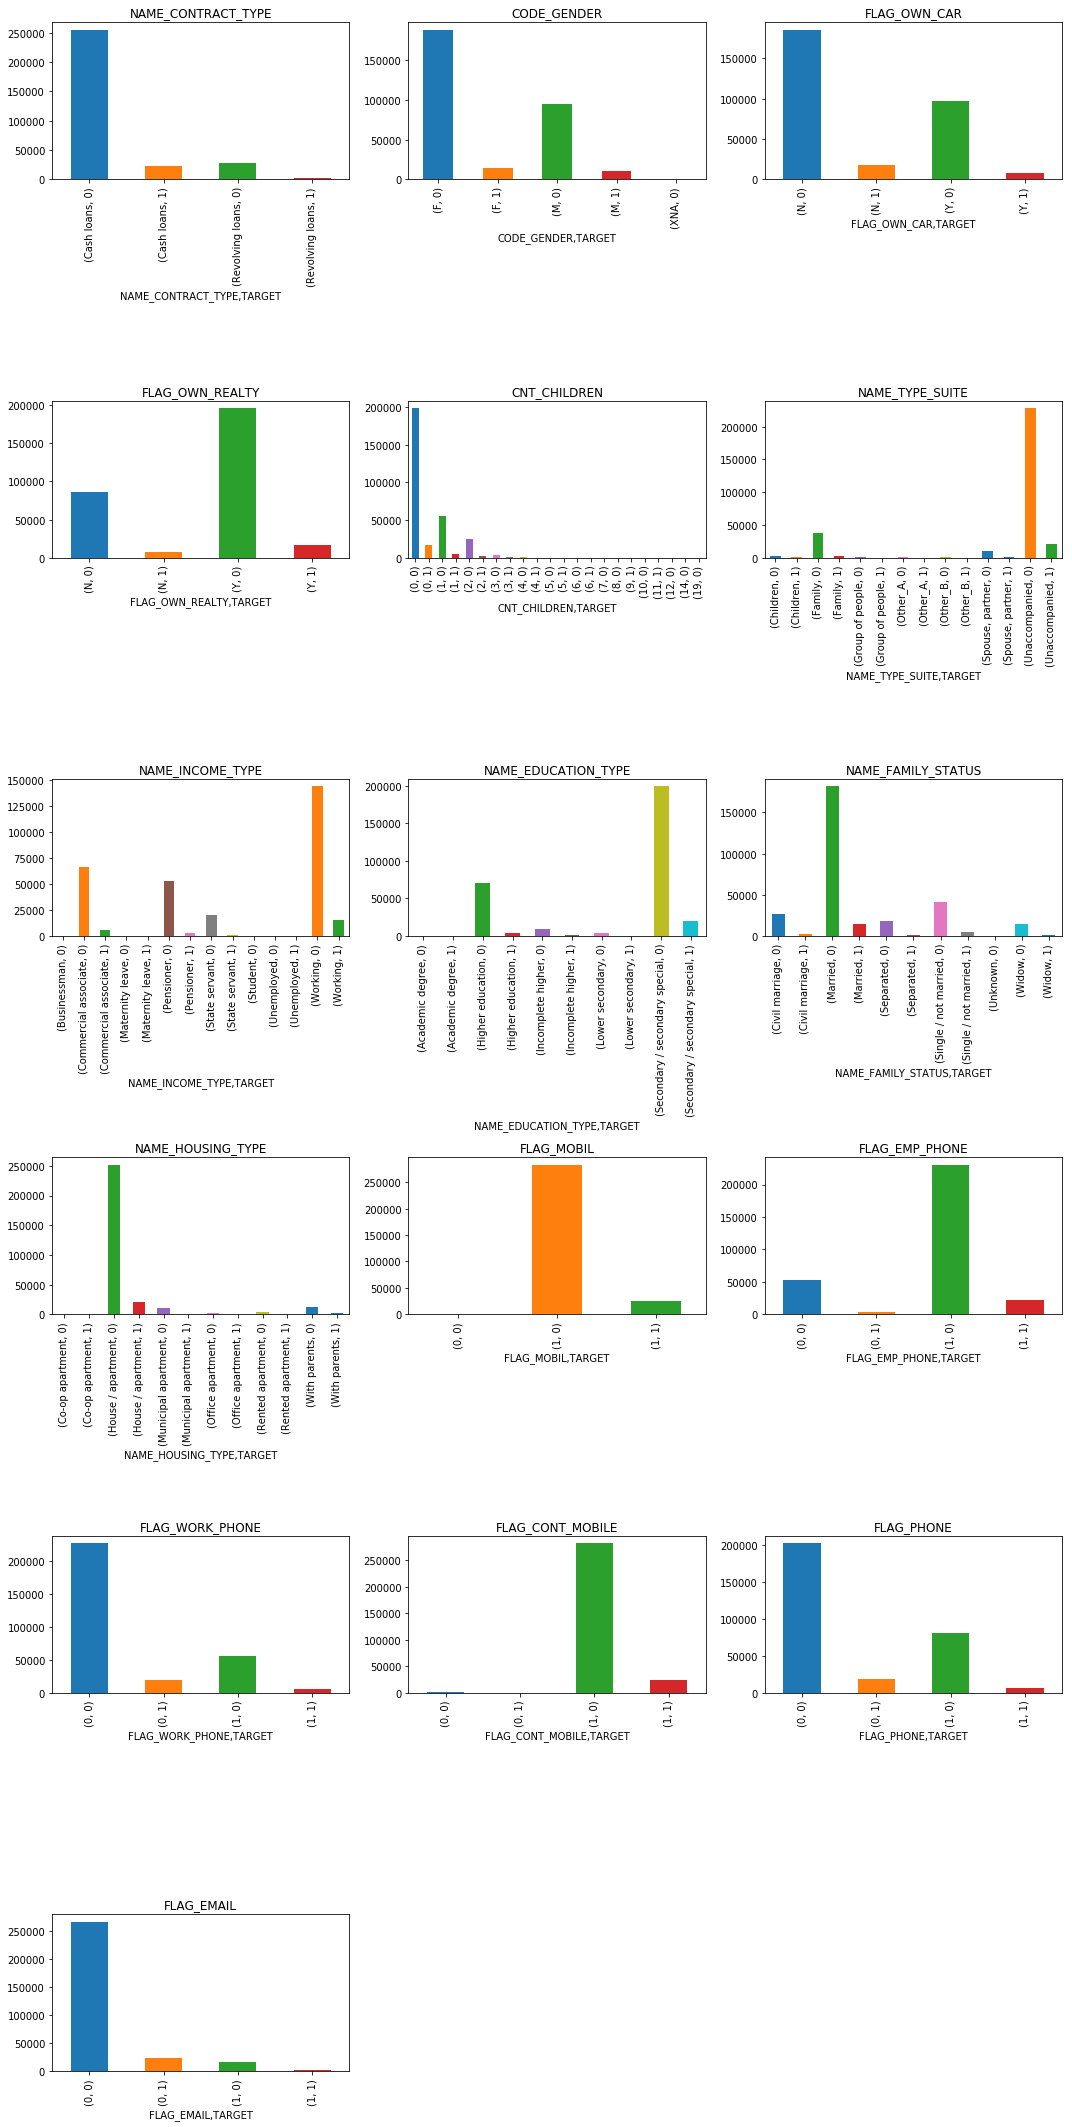

In [6]:
%matplotlib inline

plt.figure(figsize=[15, 50])
columns = ['NAME_CONTRACT_TYPE', 'CODE_GENDER',
           'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
           'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
           'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL',
           'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
           'FLAG_PHONE', 'FLAG_EMAIL',
          ]
row_no = 10
column_no = 3
for index, column in enumerate(columns):
    plt.subplot(row_no, column_no, index + 1)
    plt.title(column)
    raw_train_credit_application.groupby([column]).TARGET.value_counts().plot(kind='bar')
    
plt.tight_layout()

In [7]:
def preprocess_data(df, dataframe=False):
    new_ids = df['SK_ID_CURR'].to_frame()
    new_data = pd.DataFrame()
    if 'TARGET' in df.columns:
        new_targets = df['TARGET'].to_frame()
    else:
        new_targets = None
    
    # NAME_CONTRACT_TYPE
    new_data['contract_cash_loan'] = df['NAME_CONTRACT_TYPE'].apply(lambda val: 1 if val == 'Cash loans' else 0)
    new_data['contract_revolving_loan'] = df['NAME_CONTRACT_TYPE'].apply(lambda val: 1 if val == 'Revolving loans' else 0)
    
    # CODE_GENDER
    new_data['gender_male'] = df['CODE_GENDER'].apply(lambda val: 1 if val == 'M' else 0)
    new_data['gender_female'] = df['CODE_GENDER'].apply(lambda val: 1 if val == 'F' or val == 'XNA' else 0)
    
    if dataframe:
        try:
            new_ids = new_ids.values
        except Exception as e:
            new_ids = None
        
        try:
            new_data = new_data.values
        except Exception as e:
            new_data = None
            
        try:
            new_targets = new_targets.values
            new_targets = new_targets.reshape(-1, )
        except Exception as e:
            new_targets = None
    
    return new_ids, new_data, new_targets

# Data Split

In [8]:
raw_train_credit_application = raw_train_credit_application.reindex(np.random.permutation(raw_train_credit_application.index))

Check distribution if the randomization is fine

In [9]:
total_count = raw_train_credit_application['SK_ID_CURR'].count()
training_count = math.ceil(total_count * 0.75)
validation_count = math.floor(total_count * 0.25)

In [10]:
training_credit_application = raw_train_credit_application.head(training_count)
validation_credit_application = raw_train_credit_application.tail(validation_count)
testing_credit_application = raw_test_credit_application

In [11]:
training_ids, training_data, training_targets = preprocess_data(training_credit_application, dataframe=True)
validation_ids, validation_data, validation_targets = preprocess_data(validation_credit_application, dataframe=True)
testing_ids, testing_data, testing_targets = preprocess_data(testing_credit_application, dataframe=True)

In [12]:
training_targets_onehot = (preprocessing.OneHotEncoder().fit_transform(training_targets.reshape(-1, 1))).toarray()
validation_targets_onehot = (preprocessing.OneHotEncoder().fit_transform(validation_targets.reshape(-1, 1))).toarray()

# Data Model

In [33]:
import tensorflow as tf

from sklearn import metrics
from sklearn import linear_model, ensemble, svm

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers

sgd_classifier =  linear_model.SGDClassifier()
sgd_classifier.fit(training_data, training_targets)

svm_classifier = svm.SVC(kernel='rbf')
svm_classifier.fit(training_data, training_targets)

In [26]:
def auc_metric(y_true, y_pred):
    return tf.constant(35, name='auc')

In [35]:
default_activation = 'sigmoid'
default_last_activation = 'sigmoid'
default_batch_size = 500
default_epochs = 1

default_dnn_classifier_settings = [
    # Adam
    {'optimizer': optimizers.Adam(lr=0.01), 'batch_size': default_batch_size, 'epochs': default_epochs, 
     'activation': default_activation, 'last_activation': default_last_activation,
     'acc': None, 'val_acc': None, 'history': None, 'auc': None, 'val_auc': None},
#     {'optimizer': optimizers.Adam(lr=0.001), 'batch_size': default_batch_size, 'epochs': default_epochs, 
#      'activation': default_activation, 'last_activation': default_last_activation,
#      'acc': None, 'val_acc': None, 'history': None, 'auc': None, 'val_auc': None},
    
# #     # SGD
# #     {'optimizer': optimizers.SGD(lr=0.07, momentum=0.1), 'batch_size': default_batch_size, 'epochs': 1000,
# #      'activation': default_activation, 'last_activation': default_last_activation,
# #      'acc': None, 'val_acc': None, 'history': None, 'auc': None, 'val_auc': None},
    
#     # Adagrad
#     {'optimizer': optimizers.Adagrad(lr=0.01), 'batch_size': default_batch_size, 'epochs': default_epochs, 
#      'activation': default_activation, 'last_activation': default_last_activation,
#      'acc': None, 'val_acc': None, 'history': None, 'auc': None, 'val_auc': None},
    
#     # RMSprop
#     {'optimizer': optimizers.RMSprop(lr=0.001), 'batch_size': default_batch_size, 'epochs': default_epochs, 
#      'activation': default_activation, 'last_activation': default_last_activation,
#      'acc': None, 'val_acc': None, 'history': None, 'auc': None, 'val_auc': None},
# #     {'optimizer': optimizers.RMSprop(lr=0.0001), 'batch_size': default_batch_size, 'epochs': default_epochs, 
# #      'activation': default_activation, 'last_activation': default_last_activation,
# #      'acc': None, 'val_acc': None, 'history': None, 'auc': None, 'val_auc': None},
    
#     # Adamax
#     {'optimizer': optimizers.Adamax(lr=0.001), 'batch_size': default_batch_size, 'epochs': default_epochs, 
#      'activation': default_activation, 'last_activation': default_last_activation,
#      'acc': None, 'val_acc': None, 'history': None, 'auc': None, 'val_auc': None},
#     {'optimizer': optimizers.Adamax(lr=0.007), 'batch_size': default_batch_size, 'epochs': default_epochs, 
#      'activation': default_activation, 'last_activation': default_last_activation,
#      'acc': None, 'val_acc': None, 'history': None, 'auc': None, 'val_auc': None},
    
#     # Nadam
#     {'optimizer': optimizers.Nadam(lr=0.001), 'batch_size': default_batch_size, 'epochs': default_epochs, 
#      'activation': default_activation, 'last_activation': default_last_activation,
#      'acc': None, 'val_acc': None, 'history': None, 'auc': None, 'val_auc': None},
]

dnn_classifier_settings = []
dnn_classifier_settings.extend(default_dnn_classifier_settings)

new_settings = [
]

if len(new_settings) > 0:
    dnn_classifier_settings.extend(new_settings)

In [36]:
for index, dnn_classifier_setting in enumerate(dnn_classifier_settings):
    if dnn_classifier_setting['acc'] is None and dnn_classifier_setting['val_acc'] is None and dnn_classifier_setting['history'] is None:
        optimizer = dnn_classifier_setting['optimizer']
        batch_size = dnn_classifier_setting['batch_size']
        epochs = dnn_classifier_setting['epochs']
        activation = dnn_classifier_setting['activation']
        last_activation = dnn_classifier_setting['last_activation']

        dnn_classifier = Sequential()
        input_shape = (training_data.shape[1], )
        dnn_classifier.add(Dense(128, activation=activation, input_shape=input_shape))
        dnn_classifier.add(Dropout(rate=0.35))
        dnn_classifier.add(Dense(128, activation=activation))
        dnn_classifier.add(Dropout(rate=0.35))
        dnn_classifier.add(Dense(64, activation=activation))
        dnn_classifier.add(Dropout(rate=0.25))
        dnn_classifier.add(Dense(2, activation=last_activation))
        dnn_classifier.compile(loss='binary_crossentropy', 
                               optimizer=optimizer,
                               metrics=['acc', auc_metric])
        history = dnn_classifier.fit(training_data, training_targets_onehot,
                          epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True,
                          validation_data=(validation_data, validation_targets_onehot))

        dnn_classifier_setting['history'] = history
        
        training_predictions = dnn_classifier.predict(training_data)
        training_predictions = pd.DataFrame(training_predictions).apply(lambda val: 1.0 if val[1] > 0.50 else 0.0, axis=1)
        
        validation_predictions = dnn_classifier.predict(validation_data)
        validation_predictions = pd.DataFrame(validation_predictions).apply(lambda val: 1.0 if val[1] > 0.50 else 0.0, axis=1)
        
        dnn_classifier_setting['acc'] = metrics.accuracy_score(training_targets, training_predictions)
        dnn_classifier_setting['val_acc'] = metrics.accuracy_score(validation_targets, validation_predictions)
        dnn_classifier_setting['auc'] = metrics.roc_auc_score(training_targets, training_predictions)
        dnn_classifier_setting['val_auc'] = metrics.roc_auc_score(validation_targets, validation_predictions)

    print('%2d: Optimizer: %10s; LR: %.5f; bs: %3d; epochs: %4d; acc: %.2f; val_acc: %.2f; auc: %.2f; val_auc: %.2f' % (index, 
                                                                                              type(dnn_classifier_setting['optimizer']).__name__, 
                                                                                              dnn_classifier_setting['optimizer'].get_config()['lr'], 
                                                                                              dnn_classifier_setting['batch_size'], 
                                                                                              dnn_classifier_setting['epochs'],
                                                                                              dnn_classifier_setting['acc'], 
                                                                                              dnn_classifier_setting['val_acc'],
                                                                                              dnn_classifier_setting['auc'],
                                                                                              dnn_classifier_setting['val_auc']))

IPython.display.Audio('http://www.pacdv.com/sounds/interface_sound_effects/sound94.wav', autoplay=True)

Train on 230634 samples, validate on 76877 samples
Epoch 1/1
230634/230634 [==============================] - 6s 25us/step - loss: 0.2868 - acc: 0.9180 - auc_metric: 35.0000 - val_loss: 0.2768 - val_acc: 0.9201 - val_auc_metric: 35.0000
 0: Optimizer:       Adam; LR: 0.01000; bs: 500; epochs:    1; acc: 0.92; val_acc: 0.92; auc: 0.50; val_auc: 0.50


# Evaluation

In [38]:
classifier = dnn_classifier

In [82]:
training_predictions = classifier.predict(training_data)
print(training_predictions)
training_predictions = pd.DataFrame(training_predictions).apply(lambda val: 1.0 if val[1] > 0.1 else 0.0, axis=1)
validation_predictions = classifier.predict(validation_data)
validation_predictions = pd.DataFrame(validation_predictions).apply(lambda val: 1.0 if val[1] > 0.1 else 0.0, axis=1)

[[ 0.90574235  0.10107187]
 [ 0.90574235  0.10107187]
 [ 0.93940002  0.06408773]
 ..., 
 [ 0.93846369  0.0651821 ]
 [ 0.90574235  0.10107185]
 [ 0.93846369  0.06518212]]


In [85]:
training_targets

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [83]:
pd.Series(training_targets).value_counts()

0    211950
1     18684
dtype: int64

In [84]:
training_predictions.value_counts()

0.0    159118
1.0     71516
dtype: int64

In [76]:
print(metrics.accuracy_score(training_targets, training_predictions))
print(metrics.roc_auc_score(training_targets, training_predictions))
print(metrics.accuracy_score(validation_targets, validation_predictions))
print(metrics.roc_auc_score(validation_targets, validation_predictions))

0.918988527277
0.5
0.920119151372
0.5


# Prepare submission.csv